# 06.1l: Radial Expansion from Black Hole Cluster

**Goal:** Measure the radial extent of ultra-density around the black hole cluster.

Starting from the centroid of the 2,100 black hole tokens, we expand a hypersphere radially outward until we've captured N tokens (default: 10,000). We then report:
- The radius required
- Composition: how many are black holes vs neighbors
- Character type distribution (Thai percentage?)
- Distance distribution histogram

This reveals the **radial packing density** near the black hole core without computing problematic 2560D hypersphere volumes.

This is Volume 6: Pathologies and Singularities

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

# How many tokens to capture in the expanding hypersphere
N_TOKENS_TARGET = 10000

# Visualization parameters
COLORMAP = 'inferno'
DPI = 100

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from transformers import AutoTokenizer
from collections import defaultdict, Counter
import unicodedata

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
print("Loading gamma matrix...")
gamma_path = Path(TENSOR_DIR) / GAMMA_FILE
gamma = load_file(gamma_path)['gamma']
N, d = gamma.shape
print(f"Loaded: {gamma.shape}\n")

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded.\n")

Loading gamma matrix...
Loaded: torch.Size([151936, 2560])

Loading tokenizer...
Tokenizer loaded.



## Step 2: Identify Black Hole Tokens and Compute Centroid

In [4]:
print("Finding degenerate clusters...\n")

gamma_np = gamma.cpu().numpy()
unique_vecs, inverse_indices, counts = np.unique(
    gamma_np, 
    axis=0, 
    return_inverse=True, 
    return_counts=True
)

# Build clusters
clusters = defaultdict(list)
for token_id, unique_idx in enumerate(inverse_indices):
    clusters[unique_idx].append(token_id)

# Filter to degenerate clusters
degenerate_clusters = {idx: tokens for idx, tokens in clusters.items() if len(tokens) > 1}

# Sort by size, descending
sorted_clusters = sorted(degenerate_clusters.items(), key=lambda x: len(x[1]), reverse=True)

# Extract all black hole token IDs (top 13 clusters)
black_hole_token_ids = []
for unique_idx, token_ids in sorted_clusters[:13]:
    black_hole_token_ids.extend(token_ids)

black_hole_token_ids = sorted(black_hole_token_ids)
black_hole_set = set(black_hole_token_ids)

print(f"Identified {len(black_hole_token_ids)} black hole tokens across 13 clusters")

# Extract black hole embeddings and compute centroid
black_hole_embeddings = gamma[black_hole_token_ids]
centroid = black_hole_embeddings.mean(dim=0)
centroid_norm = torch.norm(centroid)

print(f"\nBlack hole cluster centroid:")
print(f"  Norm: {centroid_norm.item():.12f}")

Finding degenerate clusters...

Identified 2100 black hole tokens across 13 clusters

Black hole cluster centroid:
  Norm: 0.370916873217


## Step 3: Compute Distances from Centroid

In [5]:
print("\n" + "="*70)
print("COMPUTING DISTANCES FROM BLACK HOLE CENTROID")
print("="*70)
print()

print(f"Computing distance from centroid to all {N:,} tokens...\n")

# Compute Euclidean distance from centroid to every token
distances = torch.norm(gamma - centroid, dim=1)

print(f"Distance statistics:")
print(f"  Min: {distances.min().item():.12e}")
print(f"  Max: {distances.max().item():.12e}")
print(f"  Mean: {distances.mean().item():.12e}")
print(f"  Median: {distances.median().item():.12e}")


COMPUTING DISTANCES FROM BLACK HOLE CENTROID

Computing distance from centroid to all 151,936 tokens...

Distance statistics:
  Min: 1.671334393905e-05
  Max: 1.571872115135e+00
  Mean: 1.050221085548e+00
  Median: 1.088246941566e+00


## Step 4: Find Nearest N Tokens

In [6]:
print("\n" + "="*70)
print(f"FINDING {N_TOKENS_TARGET:,} NEAREST TOKENS")
print("="*70)
print()

# Sort by distance and take the nearest N
sorted_indices = torch.argsort(distances)
nearest_N_indices = sorted_indices[:N_TOKENS_TARGET]
nearest_N_distances = distances[nearest_N_indices]

# The radius is the distance to the Nth token
capture_radius = nearest_N_distances[-1].item()

print(f"Captured {N_TOKENS_TARGET:,} tokens within radius: {capture_radius:.12e} gamma units")

# Separate into black holes vs neighbors
n_black_holes_captured = sum(1 for idx in nearest_N_indices if idx.item() in black_hole_set)
n_neighbors_captured = N_TOKENS_TARGET - n_black_holes_captured

print(f"\nComposition:")
print(f"  Black hole tokens: {n_black_holes_captured:,} ({n_black_holes_captured/N_TOKENS_TARGET*100:.2f}%)")
print(f"  Neighbor tokens: {n_neighbors_captured:,} ({n_neighbors_captured/N_TOKENS_TARGET*100:.2f}%)")

# Context: compare to mean token spacing in full vocabulary
print(f"\nFor context:")
print(f"  Centroid norm: {centroid_norm.item():.12f}")
print(f"  Capture radius / centroid norm: {capture_radius / centroid_norm.item():.6f}")


FINDING 10,000 NEAREST TOKENS

Captured 10,000 tokens within radius: 8.052777051926e-01 gamma units

Composition:
  Black hole tokens: 2,100 (21.00%)
  Neighbor tokens: 7,900 (79.00%)

For context:
  Centroid norm: 0.370916873217
  Capture radius / centroid norm: 2.171046


## Step 5: Analyze Captured Tokens

In [7]:
print("\n" + "="*70)
print("CHARACTER TYPE ANALYSIS")
print("="*70)
print()

def classify_character(char):
    """Classify a character by its Unicode category."""
    if not char:
        return 'Empty'
    try:
        cat = unicodedata.category(char[0])
        name = unicodedata.name(char[0], '<UNNAMED>')
        
        if cat.startswith('L'):  # Letter
            if 'THAI' in name:
                return 'Thai'
            elif 'CJK' in name or 'HANZI' in name or 'KANJI' in name:
                return 'CJK'
            elif 'ARABIC' in name:
                return 'Arabic'
            elif 'HEBREW' in name:
                return 'Hebrew'
            elif 'LATIN' in name:
                return 'Latin'
            else:
                return 'Other Letter'
        elif cat.startswith('M'):
            return 'Diacritic'
        elif cat.startswith('Z'):
            return 'Whitespace'
        elif cat.startswith('C'):
            return 'Control'
        elif cat.startswith('P'):
            return 'Punctuation'
        elif cat.startswith('N'):
            return 'Number'
        elif cat.startswith('S'):
            return 'Symbol'
        else:
            return 'Other'
    except:
        return 'Unknown'

# Analyze character types
print(f"Analyzing character types for all {N_TOKENS_TARGET:,} captured tokens...\n")

char_types = []
for idx in nearest_N_indices:
    token_id = idx.item()
    try:
        decoded = tokenizer.decode([token_id])
        char_type = classify_character(decoded)
        char_types.append(char_type)
    except:
        char_types.append('Error')

char_type_counts = Counter(char_types)

print(f"Character type distribution:")
for char_type, count in char_type_counts.most_common():
    pct = count / len(char_types) * 100
    print(f"  {char_type:>15}: {count:>5,} ({pct:>5.1f}%)")


CHARACTER TYPE ANALYSIS

Analyzing character types for all 10,000 captured tokens...

Character type distribution:
     Other Letter: 2,446 ( 24.5%)
           Symbol: 1,622 ( 16.2%)
             Thai: 1,547 ( 15.5%)
       Whitespace: 1,120 ( 11.2%)
           Hebrew: 1,028 ( 10.3%)
              CJK:   956 (  9.6%)
           Arabic:   550 (  5.5%)
            Latin:   296 (  3.0%)
            Empty:   267 (  2.7%)
      Punctuation:   142 (  1.4%)
          Control:    13 (  0.1%)
        Diacritic:    11 (  0.1%)
           Number:     2 (  0.0%)


## Step 6: Distance Distribution


DISTANCE DISTRIBUTION



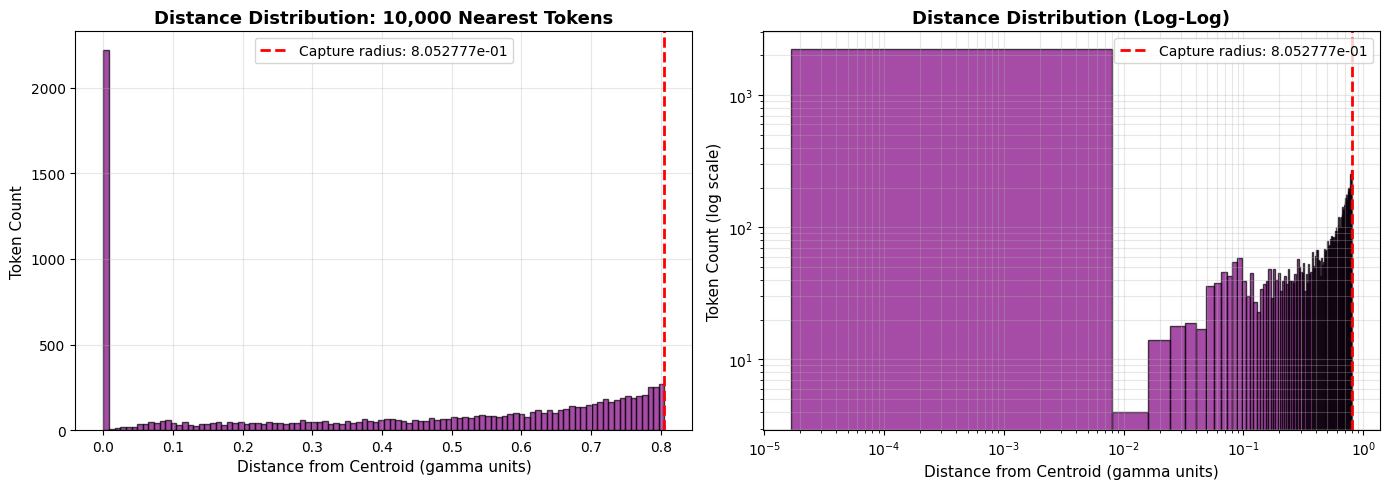


Distance statistics for 10,000 nearest tokens:
  Min: 1.671334393905e-05
  Max (capture radius): 8.052777051926e-01
  Mean: 4.266256690025e-01
  Median: 5.091040134430e-01
  Std: 2.980243861675e-01


In [8]:
print("\n" + "="*70)
print("DISTANCE DISTRIBUTION")
print("="*70)
print()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

distances_np = nearest_N_distances.cpu().numpy()

# Left: Linear scale histogram
axes[0].hist(distances_np, bins=100, color='purple', alpha=0.7, edgecolor='black')
axes[0].axvline(capture_radius, color='red', linestyle='--', linewidth=2, 
                label=f'Capture radius: {capture_radius:.6e}')
axes[0].set_xlabel('Distance from Centroid (gamma units)', fontsize=11)
axes[0].set_ylabel('Token Count', fontsize=11)
axes[0].set_title(f'Distance Distribution: {N_TOKENS_TARGET:,} Nearest Tokens', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right: Log scale (both axes)
axes[1].hist(distances_np, bins=100, color='purple', alpha=0.7, edgecolor='black')
axes[1].axvline(capture_radius, color='red', linestyle='--', linewidth=2, 
                label=f'Capture radius: {capture_radius:.6e}')
axes[1].set_xlabel('Distance from Centroid (gamma units)', fontsize=11)
axes[1].set_ylabel('Token Count (log scale)', fontsize=11)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title(f'Distance Distribution (Log-Log)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nDistance statistics for {N_TOKENS_TARGET:,} nearest tokens:")
print(f"  Min: {distances_np.min():.12e}")
print(f"  Max (capture radius): {distances_np.max():.12e}")
print(f"  Mean: {distances_np.mean():.12e}")
print(f"  Median: {np.median(distances_np):.12e}")
print(f"  Std: {distances_np.std():.12e}")

## Step 7: Cumulative Distribution


CUMULATIVE DISTRIBUTION



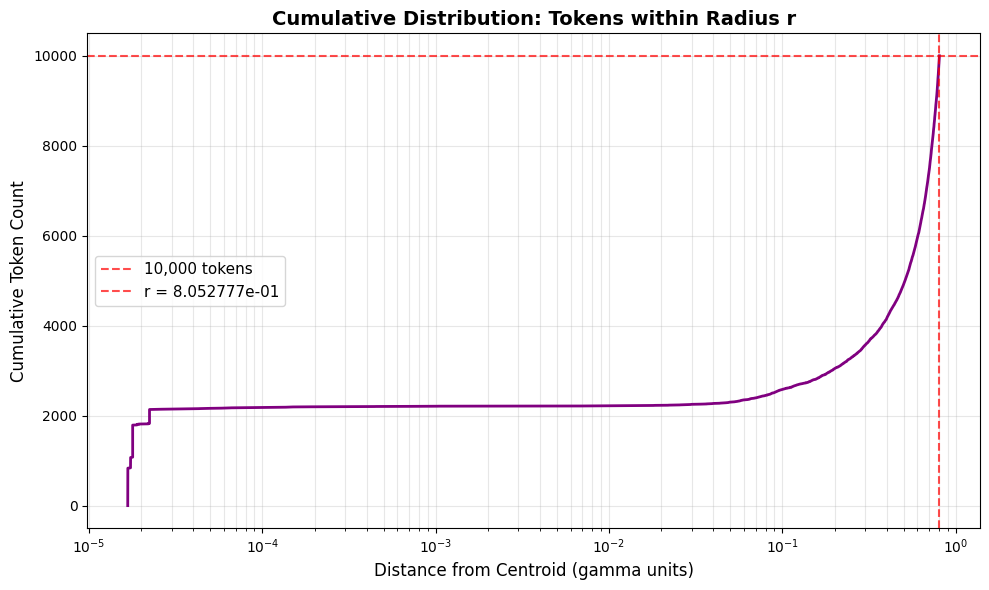


Key radii:
    100 tokens within r = 1.671334575803e-05
    500 tokens within r = 1.671334575803e-05
  1,000 tokens within r = 1.733850695018e-05
  2,500 tokens within r = 8.707811683416e-02
  5,000 tokens within r = 5.090599656105e-01
  7,500 tokens within r = 7.055090069771e-01
  10,000 tokens within r = 8.052777051926e-01


In [9]:
print("\n" + "="*70)
print("CUMULATIVE DISTRIBUTION")
print("="*70)
print()

fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

# Sort distances and compute cumulative count
sorted_distances = np.sort(distances_np)
cumulative_counts = np.arange(1, len(sorted_distances) + 1)

ax.plot(sorted_distances, cumulative_counts, color='purple', linewidth=2)
ax.axhline(N_TOKENS_TARGET, color='red', linestyle='--', linewidth=1.5, alpha=0.7,
           label=f'{N_TOKENS_TARGET:,} tokens')
ax.axvline(capture_radius, color='red', linestyle='--', linewidth=1.5, alpha=0.7,
           label=f'r = {capture_radius:.6e}')

ax.set_xlabel('Distance from Centroid (gamma units)', fontsize=12)
ax.set_ylabel('Cumulative Token Count', fontsize=12)
ax.set_title(f'Cumulative Distribution: Tokens within Radius r', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3, which='both')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# Report key radii
print(f"\nKey radii:")
for n in [100, 500, 1000, 2500, 5000, 7500, 10000]:
    if n <= len(sorted_distances):
        r = sorted_distances[n-1]
        print(f"  {n:>5,} tokens within r = {r:.12e}")

## Step 8: Radial Shell Analysis

Divide the capture region into logarithmic shells and count tokens in each.

In [10]:
print("\n" + "="*70)
print("RADIAL SHELL ANALYSIS")
print("="*70)
print()

# Define logarithmic shell boundaries
shell_edges = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]

print(f"{'Shell':^6} {'r_inner':>12} {'r_outer':>12} {'Count':>10} {'Cumulative':>12}")
print("-" * 60)

cumulative = 0
for i in range(len(shell_edges) - 1):
    r_inner = shell_edges[i]
    r_outer = shell_edges[i + 1]
    
    in_shell = (distances_np > r_inner) & (distances_np <= r_outer)
    count = in_shell.sum()
    cumulative += count
    
    print(f"{i:^6} {r_inner:>12.2e} {r_outer:>12.2e} {count:>10,} {cumulative:>12,}")
    
    if cumulative >= N_TOKENS_TARGET:
        break

print()
print(f"Total tokens captured: {cumulative:,}")


RADIAL SHELL ANALYSIS

Shell       r_inner      r_outer      Count   Cumulative
------------------------------------------------------------
  0        0.00e+00     1.00e-08          0            0
  1        1.00e-08     1.00e-07          0            0
  2        1.00e-07     1.00e-06          0            0
  3        1.00e-06     1.00e-05          0            0
  4        1.00e-05     1.00e-04      2,183        2,183
  5        1.00e-04     1.00e-03         27        2,210
  6        1.00e-03     1.00e-02         11        2,221
  7        1.00e-02     1.00e-01        365        2,586
  8        1.00e-01     1.00e+00      7,414       10,000

Total tokens captured: 10,000


## Summary

We've expanded radially from the black hole cluster centroid to capture {N_TOKENS_TARGET:,} tokens.

**Key findings:**
1. **Capture radius:** See above - the radius needed to encompass {N_TOKENS_TARGET:,} tokens
2. **Composition:** Black holes vs neighbors
3. **Character distribution:** Percentage of Thai tokens in the captured region
4. **Packing density:** How tightly tokens are packed near the black hole core

**Interpretation:**
- If the capture radius is tiny (< 0.001 gamma units): The black hole cluster is surrounded by thousands of ultra-dense neighbors, all packed within a few bfloat16 lattice cells
- If the capture radius is moderate (~0.01): The density falls off gradually
- If the capture radius is large (> 0.1): We're capturing the full accretion disk + exclusion zone

The radial shell analysis shows how density varies with distance from the singularity.